### Team information:
Member_1_Email: david.loka@student.guc.edu.eg

Member_1_Name: David Mina

Member_1_ID: 37-3742
* * *
Member_2_Email: amgad.mekahel@student.guc.edu.eg

Member_2_Name: Amgad Ashraf

Member_2_ID: 37-2058
* * *
Member_3_Email: shady.younan@student.guc.edu.eg

Member_3_Name: Shady Sherif

Member_3_ID: 37-3236
* * *
Member_4_Email: nader.wahba@student.guc.edu.eg

Member_4_Name: Nader Waguih

Member_4_ID: 37-6772
* * *
Member_5_Email: bishoy.aziz@student.guc.edu.eg

Member_5_Name: Bishoy Raafat

Member_5_ID: 37-15522

# COVID-19 Task1: transmission, incubation, and environmental stability
Since the outbreak of the COVID-19 pandemic, researchers have been doing their utmost to gain insights into the different aspects related to this infectious disease, which will help the world be in control of this unprecedented situation and assist the medical community in reaching an effective cure in the shortest time possible. Believing that every small step in the right direction counts, it was essential to take an active role and lend a helping hand by applying some natural language processing techniques on the provided CORD-19 dataset so that researchers can easily and quickly keep up with the literature in this context.

### About this notebook
In this notebook, our main focus is to help researchers find the most relevant articles, from the overwhelming number of documents published, in an attempt to answer the questions provided in task1. We also aim to perform literature clustering so that similar articles are grouped in one cluster to ease the search process per topic.   

### Table of Contents
1. [Importing the metadata.csv to work with the abstracts](#1)
2. [Data Cleaning](#2)
3. [Text Preprocessing](#3) <br>
a. [tokenization](#3) <br>
b. [stopwords removal](#3) <br>
c. [lemmatization](#3) 
4. [Building BM25 index from the abstracts and retrieving the most relevant articles for some of the task's questions](#4)
5. [Performance Evaluation](#5)
6. [Training Doc2Vec model on the abstracts](#6)
7. [Clustering and Visualization using k-means and PCA](#7)
8. [A WordCloud showing the most frequent words in articles' titles](#8)

<a id='1'></a>
## 1. Importing the metadata.csv file

In [1]:
import numpy as np
import pandas as pd 

metadata_df = pd.read_csv('metadata.csv')
metadata_df.head()

/Users/AmgadAshraf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723.0,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663.0,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


<a id='2'></a>
## 2. Data Cleaning
### Finding the number of records with missing abstract, doi or title

In [2]:
missing_values_count_per_col = metadata_df.isnull().sum()
print('Entries without abstract BEFORE: '+ str(missing_values_count_per_col['abstract']))
print('Entries without doi BEFORE: '+ str(missing_values_count_per_col['doi']))
print('Entries without title BEFORE: '+ str(missing_values_count_per_col['title']))

Entries without abstract BEFORE: 11130
Entries without doi BEFORE: 4086
Entries without title BEFORE: 163


### Visualizing the percentage of missing values in each column of the metadata.csv file

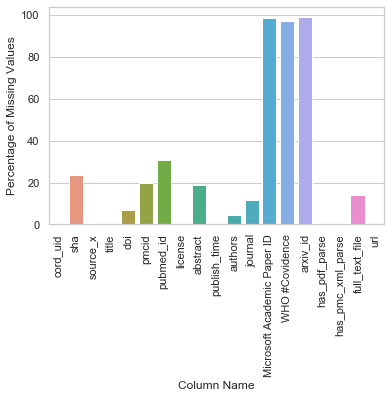

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

missing_values_count_per_col = metadata_df.isnull().sum()/len(metadata_df) * 100
missing_values_count_per_col = missing_values_count_per_col.to_frame()
missing_values_count_per_col.columns = ['Percentage of Missing Values']
missing_values_count_per_col.index.names = ['Column Name']
missing_values_count_per_col['Column Name'] = missing_values_count_per_col.index

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x='Column Name', y='Percentage of Missing Values', data=missing_values_count_per_col)
plt.xticks(rotation = 90)
plt.show()

### Dropping records with missing abstract, doi or title

In [5]:
metadata_df = metadata_df.dropna(how='any', subset=['abstract','doi', 'title'])
missing_values_count_per_col = metadata_df.isnull().sum()
print('Entries without abstract AFTER: '+ str(missing_values_count_per_col['abstract']))
print('Entries without doi AFTER: '+ str(missing_values_count_per_col['doi']))
print('Entries without title AFTER: '+ str(missing_values_count_per_col['title']))

Entries without abstract AFTER: 0
Entries without doi AFTER: 0
Entries without title AFTER: 0


### Dropping the duplicate rows based on the doi

In [6]:
#Select all duplicate rows based on DOI
duplicateRowsDF = metadata_df[metadata_df.duplicated(['doi'])]
print("Duplicate rows based on DOI: " + str(duplicateRowsDF['doi'].count()))
metadata_df = metadata_df.drop_duplicates(subset='doi', keep="first")
metadata_df = metadata_df.reset_index(drop=True)

Duplicate rows based on DOI: 12


<a id='3'></a>
## 3. Text Preprocessing
### Implementing a function to tokenize, lemmatize and remove the stopwords from input text

In [7]:
from nltk import word_tokenize, sent_tokenize
import re
from nltk.stem import WordNetLemmatizer 
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

nlp = English()
lemmatizer = WordNetLemmatizer()

def tokenize_and_remove_stopwords(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token): #regular expression to eliminate special characters in text
            filtered_tokens.append(token)
    tokens_after_stopwords_removal = []
    for token in filtered_tokens:
        lexeme = nlp.vocab[token]
        if not lexeme.is_stop:
            lemmatized_token = lemmatizer.lemmatize(token)
            tokens_after_stopwords_removal.append(lemmatized_token)
    return tokens_after_stopwords_removal

### Calling the implemented function on the abstracts

In [8]:
clean_abstracts = []
for i in range(0, metadata_df.shape[0]):
    abstract = metadata_df.iloc[i]['abstract']
    clean_abstracts.append(tokenize_and_remove_stopwords(abstract))

<a id='4'></a>
## 4. Building BM25 index from the preprocessed abstracts and retrieving the top n-relevant documents to a search query based on BM25 scores

In [9]:
from rank_bm25 import BM25Okapi
import numpy as np

bm25_index = BM25Okapi(clean_abstracts) #building the index

def retrieve_most_relevant(search_query, n):
    search_tokens = tokenize_and_remove_stopwords(search_query)
    scores = bm25_index.get_scores(search_tokens)
    top_indexes = np.argsort(scores)[::-1][:n]
    return top_indexes, scores[top_indexes]

## Task 1 Sample Questions: Top 10 Relevant Papers (title, abstract and doi)

### Q1: What is the range of incubation periods for the coronavirus disease in humans?

In [10]:
indexes, scores = retrieve_most_relevant('Range of incubation periods for the coronavirus in humans', 10)
metadata_df.loc[indexes, ['title', 'abstract', 'doi']]

Column Name,title,abstract,doi
38680,Incubation periods of acute respiratory viral ...,Summary Knowledge of the incubation period is ...,10.1016/s1473-3099(09)70069-6
33966,A Chinese Case of Coronavirus Disease 2019 (CO...,Controversy remains over whether the coronavir...,10.3961/jpmph.20.048
29197,Estimate the incubation period of coronavirus ...,Motivation: Wuhan pneumonia is an acute infect...,10.1101/2020.02.24.20027474
21212,Incubation Period Duration and Severity of Cli...,BACKGROUND: Few previous studies have investig...,10.1097/ede.0000000000000339
6810,Comparison of incubation period distribution o...,The incubation period is an important epidemio...,10.1038/srep35839
44197,The Incubation Period of Coronavirus Disease 2...,"BACKGROUND: A novel human coronavirus, severe ...",10.7326/m20-0504
5946,Association between the Severity of Influenza ...,"BACKGROUND: In early 2013, a novel avian-origi...",10.1371/journal.pone.0148506
29055,Estimating the distribution of the incubation ...,Objectives: Amid the continuing spread of the ...,10.1101/2020.02.13.20022822
43530,Transmission of COVID-19 in the terminal stage...,Abstract We report a familial cluster of 2019 ...,10.1016/j.ijid.2020.03.027
29384,Estimation of incubation period distribution o...,Background: The current outbreak of coronaviru...,10.1101/2020.03.06.20032417


### Q2: What is the seasonality of the coronavirus transmission?

In [11]:
indexes, scores = retrieve_most_relevant('Seasonality of the coronavirus transmission', 10)
metadata_df.loc[indexes, ['title', 'abstract', 'doi']]

Column Name,title,abstract,doi
41108,Study of surveillance data for class B notifia...,Summary Background The surveillance of infecti...,10.1016/j.ijid.2016.04.010
31612,Projecting the end of the Zika virus epidemic ...,AbstractBackground Zika virus (ZIKV) emerged i...,10.1101/323915
9563,Seasonality and clinical impact of human parai...,BACKGROUND: Widespread availability of rapid d...,10.1111/irv.12597
12532,Seasonality and prevalence of respiratory path...,Respiratory tract infections (RTIs) are a lead...,10.1007/s00705-013-1794-4
12225,Chaos in a seasonally perturbed SIR model: avi...,Seasonality is a complex force in nature that ...,10.1007/s00285-012-0550-9
15671,Detection of new respiratory viruses in hospit...,Aim: We have designed a study with the objecti...,10.1111/j.1651-2227.2010.01714.x
15037,"Underlying trend, seasonality, prediction, for...",This study set out to identify and analyse tre...,10.1017/s0950268818001541
32711,Seasonal synchrony in incidences of common inf...,Summary Objectives Information on seasonal syn...,10.1016/j.ijid.2014.06.015
19002,Within-mother analysis of seasonal patterns in...,A large literature describes relationships bet...,10.1073/pnas.1307582110
32101,Consideration and prevention for the aerosol t...,Novel coronavirus pneumonia broke out from Wuh...,10.3760/cma.j.cn112142-20200313-00181


### Q3: How does the environment affect the coronavirus transmission? 

In [37]:
indexes, scores = retrieve_most_relevant('Role of environment in coronavirus transmission', 10)
metadata_df.loc[indexes, ['title', 'abstract', 'doi']]

Column Name,title,abstract,doi
38131,Viruses and the nucleolus: The fatal attraction,Abstract Viruses are small obligatory parasite...,10.1016/j.bbadis.2013.12.010
2036,The Effects of Temperature and Relative Humidi...,The main route of transmission of SARS CoV inf...,10.1155/2011/734690
29262,Closed environments facilitate secondary trans...,Commissioned by the Minister of the Ministry o...,10.1101/2020.02.28.20029272
29044,The role of absolute humidity on transmission ...,A novel coronavirus (COVID-19) was identified ...,10.1101/2020.02.12.20022467
17291,Essential Role of Patient Blood Management in ...,The World Health Organization (WHO) has declar...,10.1213/ane.0000000000004844
40930,Distribution of bat-borne viruses and environm...,Abstract Environmental modifications are leadi...,10.1016/j.meegid.2017.12.009
16172,"Routes of transmission of influenza A H1N1, SA...",Identifying the exact transmission route(s) of...,10.1111/ina.12445
27438,"Coronavirus in water environments: Occurrence,...",Abstract Coronaviruses (CoV) are a large famil...,10.1016/j.watres.2020.115899
43471,Isolation and identification of human coronavi...,Frequently touched surfaces of a university cl...,10.1016/j.ajic.2017.07.014
24232,The Effect of Turbulence on the Spreading of I...,The dispersion of droplets plays an important ...,10.1007/978-94-007-2506-5_9


### Q4: How does the immune system of humans respond to the coronavirus?

In [41]:
indexes, scores = retrieve_most_relevant('Immune response to coronavirus', 10)
metadata_df.loc[indexes, ['title', 'abstract', 'doi']]

Column Name,title,abstract,doi
37928,A Sequence Homology and Bioinformatic Approach...,Summary Effective countermeasures against the ...,10.1016/j.chom.2020.03.002
14831,Human enteric Coronaviruses: Antigenic Related...,In a group of infants with acute nonbacterial ...,10.1093/infdis/151.5.796
40109,Chapter 1 Introduction to the Immune Response,Abstract In this chapter we provide an overvie...,10.1016/b978-0-12-385245-8.00001-7
29047,Candidate targets for immune responses to 2019...,ABSTRACTEffective countermeasures against the ...,10.1101/2020.02.12.946087
36077,Treatment of cats with feline infectious perit...,Abstract Feline infectious peritonitis (FIP) i...,10.1016/j.vetimm.2008.01.026
15764,Do checkpoint inhibitors compromise the cancer...,The severe acute respiratory syndrome coronavi...,10.2217/imt-2020-0077
28297,Improving Vaccine-Induced Immunity: Can Baseli...,Immune signatures measured at baseline and imm...,10.1016/j.it.2020.04.001
29524,Blood single cell immune profiling reveals the...,The coronavirus disease 2019 (COVID-19) outbre...,10.1101/2020.03.15.20033472
34450,Canine Coronavirus,Publisher Summary This chapter provides an ove...,10.1016/b978-0-12-524180-9.50033-9
30013,Epitope-based chimeric peptide vaccine design ...,Severe acute respiratory syndrome coronavirus ...,10.1101/2020.03.30.015164


<a id='5'></a>
## 5. Performance Evaluation 
**Approach:** calculating precision @k for each question, AP and then MAP

In order to evaluate the ranked results returned, we will rely on the precision and mean average precision (MAP) evaluation metrics. Since we do not have labelled data of the relevant documents, we read each abstract retrieved for every question to know whether it is actually relevant to the search query or not and be able to measure precision.

#### Precision @k:
computes the number of relevant documents in the top-k results of the system. In our case, we retrieve the top 10 documents (k=10).
#### Average Precision (AP):
considers the rank position of each *relevant* document only. AP = average of precision @k for k=1 to n of *relevant* documents.
#### Mean Average Precision (MAP):
calculates the average precision across several queries.


## Q1: 
### $$Precision @k = [\frac{1}{1},\frac{2}{2},\frac{3}{3},\frac{4}{4},\frac{5}{5},\frac{6}{6},\frac{6}{7},\frac{6}{8},\frac{6}{9},\frac{7}{10}]$$
### $$AP = \frac{1}{7} * (\frac{1}{1}+\frac{2}{2}+\frac{3}{3}+\frac{4}{4}+\frac{5}{5}+\frac{6}{6}+\frac{7}{10}) = 0.96$$
## Q2: 
### $$Precision @k = [\frac{1}{1},\frac{1}{2},\frac{2}{3},\frac{3}{4},\frac{3}{5},\frac{4}{6},\frac{5}{7},\frac{5}{8},\frac{5}{9},\frac{5}{10}]$$
### $$AP = \frac{1}{5} * (\frac{1}{1}+\frac{2}{3}+\frac{3}{4}+\frac{4}{6}+\frac{5}{7}) = 0.76$$
## Q3: 
### $$Precision @k = [\frac{0}{1},\frac{1}{2},\frac{2}{3},\frac{3}{4},\frac{3}{5},\frac{4}{6},\frac{5}{7},\frac{6}{8},\frac{7}{9},\frac{7}{10}]$$
### $$AP = \frac{1}{7} * (\frac{1}{2}+\frac{2}{3}+\frac{3}{4}+\frac{4}{6}+\frac{5}{7}+\frac{6}{8}+\frac{7}{9}) = 0.69$$
## Q4: 
### $$Precision @k = [\frac{1}{1},\frac{2}{2},\frac{2}{3},\frac{3}{4},\frac{4}{5},\frac{5}{6},\frac{5}{7},\frac{6}{8},\frac{6}{9},\frac{7}{10}]$$
### $$AP = \frac{1}{7} * (\frac{1}{1}+\frac{2}{2}+\frac{3}{4}+\frac{4}{5}+\frac{5}{6}+\frac{6}{8}+\frac{7}{10}) = 0.83$$

### $$MAP = \frac{0.96 + 0.76 + 0.69 + 0.83}{4} = 0.81$$

<a id='6'></a>
## 6. Training the Doc2Vec model on the abstracts

To understand how doc2vec works, we first have to give a brief on the concept of word2vec. Word2vec is a well-known embedding method that numerically represents a word taking the different relations between words. The concept of word2vec is that we train a neural network to either predict a word from the surrounding ones (context) using continuous bag of words (CBOW) model or vice versa - use one word to predict the neighbouring ones using skip gram model. 

Doc2vec extends this concept by augmenting the word2vec model with a unique feature vector for each document. Thus, after training, each document has a numeric representation. Doc2vec is considered to be powerful in capturing similarities between documents, which makes it a suitable approach for our purpose of documents clustering. 

#### Preparing the preprocessed abstracts (training data) to be in the format required by the gensim doc2vec model 

In [14]:
import gensim
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

labelled_abstracts=[]
for i in range(0, len(clean_abstracts)):
    if len(clean_abstracts[i]) > 50:
        labelled_abstracts.append(TaggedDocument(clean_abstracts[i], [i]))
print(labelled_abstracts[0])     

TaggedDocument(['Nidovirus', 'subgenomic', 'mRNAs', 'contain', 'leader', 'sequence', 'derived', 'end', 'genome', 'fused', 'different', 'sequence', 'body', 'derived', 'end', 'generation', 'involves', 'unique', 'mechanism', 'discontinuous', 'subgenomic', 'RNA', 'synthesis', 'resembles', 'copy-choice', 'RNA', 'recombination', 'process', 'nascent', 'RNA', 'strand', 'transferred', 'site', 'template', 'plus', 'minus', 'strand', 'synthesis', 'yield', 'subgenomic', 'RNA', 'molecule', 'Central', 'process', 'transcription-regulating', 'sequence', 'TRSs', 'present', 'template', 'site', 'ensure', 'fidelity', 'strand', 'transfer', 'present', 'result', 'comprehensive', 'co-variation', 'mutagenesis', 'study', 'equine', 'arteritis', 'virus', 'TRSs', 'demonstrating', 'discontinuous', 'RNA', 'synthesis', 'depends', 'base', 'pairing', 'sense', 'leader', 'TRS', 'antisense', 'body', 'TRS', 'primary', 'sequence', 'body', 'TRS', 'leader', 'TRS', 'merely', 'play', 'targeting', 'role', 'strand', 'transfer', 'b

#### Building the gensim doc2vec model and training on our data for 20 epochs 

In [15]:
model = Doc2Vec(labelled_abstracts)

In [16]:
for epoch in range(20):
    model.train(labelled_abstracts,epochs=model.iter,total_examples=model.corpus_count)
    print("Epoch #{} is complete.".format(epoch+1))

/Users/AmgadAshraf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


Epoch #1 is complete.
Epoch #2 is complete.
Epoch #3 is complete.
Epoch #4 is complete.
Epoch #5 is complete.
Epoch #6 is complete.
Epoch #7 is complete.
Epoch #8 is complete.
Epoch #9 is complete.
Epoch #10 is complete.
Epoch #11 is complete.
Epoch #12 is complete.
Epoch #13 is complete.
Epoch #14 is complete.
Epoch #15 is complete.
Epoch #16 is complete.
Epoch #17 is complete.
Epoch #18 is complete.
Epoch #19 is complete.
Epoch #20 is complete.


<a id='7'></a>
## 7. Clustering and Visualization using k-means and PCA

/Users/AmgadAshraf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """
/Users/AmgadAshraf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  import sys
/Users/AmgadAshraf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/Users/AmgadAshraf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if __name__ == '__main__':


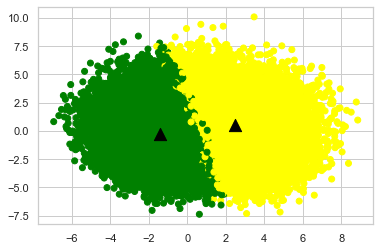

In [17]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100) 
X = kmeans_model.fit(model.docvecs.doctag_syn0)
labels = kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

%matplotlib inline
plt.figure
label1 = ["#FFFF00", "#008000"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()


#### A function to retrieve the indices of the abstracts belonging to each cluster

In [18]:
def ClusterIndicesNumpy(clustNum, labels_array): 
    return np.where(labels_array == clustNum)[0]

#### Using frequency distribution to get the most common 10 keywords per cluster with their frequency 

In [19]:
from nltk.probability import FreqDist
for i in range(0,len(centroids)):
    abstracts_list_cluster = []
    np_array = ClusterIndicesNumpy(i, kmeans_model.labels_)
    abstracts_list_cluster = np_array.tolist()
    total_abstracts_cluster = []
    for index in abstracts_list_cluster:
        total_abstracts_cluster.append(np.array(clean_abstracts[index]))

    total_abstracts_cluster = np.concatenate(total_abstracts_cluster).ravel().tolist() 
    fdist = FreqDist(total_abstracts_cluster)
    top_ten_keywords = fdist.most_common(10)
    print("Top ten keywords sorted by frequency in cluster", i, top_ten_keywords)

Top ten keywords sorted by frequency in cluster 0 [('virus', 43809), ('cell', 34855), ('protein', 27628), ('infection', 25032), ('viral', 20060), ('disease', 16833), ('human', 15142), ('study', 14452), ('response', 11740), ('gene', 11597)]
Top ten keywords sorted by frequency in cluster 1 [('patient', 22167), ('infection', 17953), ('virus', 17445), ('disease', 14857), ('study', 14320), ('respiratory', 14069), ('case', 12504), ('health', 9396), ('COVID-19', 8360), ('influenza', 8219)]


<a id='8'></a>
## 8. A WordCloud showing the most frequent words in articles' titles

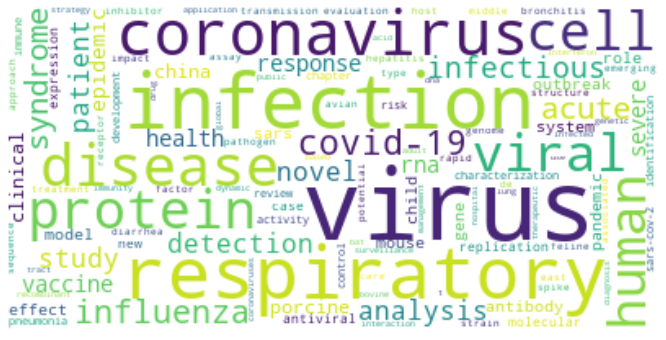

In [23]:
from wordcloud import WordCloud
from nltk.probability import FreqDist

clean_titles = []
for title in metadata_df.title:
    clean_titles.append(tokenize_and_remove_stopwords(title.lower()))
text = np.concatenate(clean_titles).ravel().tolist()
fdist_titles = FreqDist(text)
wordcloud = WordCloud(background_color="white", max_font_size=60).generate_from_frequencies(fdist_titles)

plt.figure(figsize=[12,6])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()